# Set up environment

In [1]:
source("Pathway_config.R")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: org.Hs.eg.db
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append,

```
Your Folder Structure:  
└── HTS2018  
    ├── out  
    │   └── hts-pilot-2018.RData  
    |   └── HTS-Pilot-Annotated-STAR-counts.RData
    └── Info
        ├── pathway_genes.txt
        └── pathway_names.txt
```

# Read in data

## Import count table

```
### Step 0. Attach count data (from KO's STAR pipeline)
### Be sure to first run
### $ R CMD BATCH demodata.R
### to create R object with count data
### This must be replaced with the count data from the
### "official" pipeline (ask Josh if unsure)
### The relevant object names are countData and columnData
### These are based on the aggregating the counts over the
### four lanes
demofile <- "HTS-2018-pilot-demo-data.RData"
attach(demofile)
tools::md5sum(demofile)
```

In [5]:
attach(file.path(OUTDIR, "HTS-Pilot-Annotated-STAR-counts.RData"))

The following objects are masked from file:/home/jovyan/work/scratch/analysis_output/out/HTS-Pilot-Annotated-STAR-counts.RData (pos = 4):

    annogenecnts, annogenecnts0, annomapres, annomapres0, mtdf



## Import pathway information

Read in the names and gene lists

In [3]:
attach(file.path(OUTDIR, "pathway_genesets.RData"))

# Creat DESeq object

Observe the count matrix

In [4]:
head(annogenecnts0)

gene,1_MA_J,1_RZ_J,10_MA_C,10_RZ_C,11_MA_J,11_RZ_J,12_MA_P,12_RZ_P,13_MA_J,⋯,4_RZ_P,4_TOT_P,40_MA_J,40_RZ_J,45_MA_P,45_RZ_P,47_MA_P,47_RZ_P,9_MA_C,9_RZ_C
CNAG_00001,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,265,204,269,76,130,92,205,64,308,⋯,51,13,519,235,410,122,534,112,217,106
CNAG_00003,112,40,171,24,124,18,150,34,221,⋯,11,8,218,53,232,46,240,41,128,35
CNAG_00004,301,207,407,141,272,179,351,156,533,⋯,50,36,719,442,518,238,622,277,310,234
CNAG_00005,114,125,50,25,38,32,38,12,202,⋯,25,14,344,270,202,81,256,118,45,40
CNAG_00006,1904,1295,3571,1015,2073,1327,3003,926,1660,⋯,319,110,3002,1535,3934,1090,4966,1132,3313,1509


Observe the metadata

In [6]:
head(annomapres0)

Label,Strain,Media,experiment_person,libprep_person,enrichment_method,prob.gene,prob.nofeat,prob.unique,depth
1_MA_J,H99,YPD,expA,prepB,MA,0.9641456,0.008161923,0.9723075,2493464
1_RZ_J,H99,YPD,expA,prepB,RZ,0.6689001,0.217095621,0.8859957,3541358
10_MA_C,mar1d,YPD,expA,prepA,MA,0.9618651,0.009818573,0.9716837,3282785
10_RZ_C,mar1d,YPD,expA,prepA,RZ,0.7497438,0.200651686,0.9503955,1742594
11_MA_J,mar1d,YPD,expA,prepB,MA,0.9669597,0.008717898,0.9756776,2062181
11_RZ_J,mar1d,YPD,expA,prepB,RZ,0.7030020,0.195547151,0.8985491,2621913


In [7]:
genesets_cne_h99[1]

$`ec00010 | Glycolysis / Gluconeogenesis`
 [1] "CNAG_00038" "CNAG_00057" "CNAG_00515" "CNAG_00735" "CNAG_00797"
 [6] "CNAG_01078" "CNAG_01120" "CNAG_01675" "CNAG_01820" "CNAG_01955"
[11] "CNAG_02035" "CNAG_02377" "CNAG_02489" "CNAG_02736" "CNAG_02903"
[16] "CNAG_03072" "CNAG_03358" "CNAG_03916" "CNAG_04217" "CNAG_04523"
[21] "CNAG_04659" "CNAG_04676" "CNAG_05059" "CNAG_05113" "CNAG_06035"
[26] "CNAG_06313" "CNAG_06628" "CNAG_06699" "CNAG_06770" "CNAG_07004"
[31] "CNAG_07316" "CNAG_07559" "CNAG_07660" "CNAG_07745"

Prepare columnData (DataFrameand countData (matrix object). Let's select samples from RZ

In [8]:
annomapres0 %>%
    dplyr::filter(enrichment_method == "RZ")  %>%
    DataFrame ->
    columnData
rownames(columnData) <- columnData[["Label"]]

### the code below show you the sample that will be analyzed in this example
annogenecnts0 %>%
    dplyr::select(dput(as.character(c("gene",columnData[["Label"]])))) %>%
    as.data.frame %>%
    column_to_rownames("gene") %>%
    as.matrix ->
    countData

c("gene", "1_RZ_J", "10_RZ_C", "11_RZ_J", "12_RZ_P", "13_RZ_J", 
"14_RZ_C", "15_RZ_C", "16_RZ_P", "2_RZ_C", "21_RZ_C", "22_RZ_C", 
"23_RZ_J", "24_RZ_J", "26_RZ_C", "27_RZ_P", "3_RZ_J", "35_RZ_P", 
"36_RZ_J", "38_RZ_P", "4_RZ_P", "40_RZ_J", "45_RZ_P", "47_RZ_P", 
"9_RZ_C")


Conduct DESeq2 Differential Expression (DE) Analysis

In [9]:
### Make DESeq2 data object
dds <- DESeq2::DESeqDataSetFromMatrix(countData, columnData,  ~ Media + Strain + Media:Strain)
### Conduct DE analysis
dds <- DESeq2::DESeq(dds)
### Rlog "normalized" expressions
rld <- rlog(dds)
### Get results from DESeq2 DE analysis
ddsres <- DESeq2::results(dds, contrast = c("Media", "YPD" , "TC"))
### Extract the estimated fold changes
ddsfc <- ddsres$log2FoldChange
### Assign the gene name to the fold change vector
names(ddsfc) <- rownames(ddsres)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


# Pathway analysis performed using gage package

Calculate pathway level statistics using the gage package

In [11]:
### Notes
### This example is using the estimated fold changes for DESeq2 for the inference
### Accordingly, use.fold is set to TRUE and the indices for the ref and target
### samples are set to NULL. The theory behind using fold changes is iffy
### Also, it puts limits on min and max on gene set sizes. This is a tuning parameter
### and our choices are arbitrary.
### Finally, it tests whether within a gene set the genes point in the same direction

gageres01 <- gage::gage(ddsfc,
                      gsets = genesets_cne_h99,
                      use.fold = TRUE,
                      ref = NULL, 
                      samp = NULL,  
                      set.size = c(10, 500),
                      same.dir = TRUE) 

In [12]:
### Geneset analysis using the "microarray" approach. We will use rlog
### transformed expressions for the purpose of this demonstration

gageres02 <- gage::gage(assay(rld),
                      gsets = genesets_cne_h99,
                      use.fold = FALSE,
                      ref = which(colData(rld)[["Media"]]=="TC"), 
                      samp = which(colData(rld)[["Media"]]=="YPD"),
                      compare = "unpaired",
                      set.size = c(10, 500),
                      same.dir = TRUE) 

In [23]:
gageres01$greater %>% head(3)

,p.geomean,stat.mean,p.val,q.val,set.size,exp1
TRNA-CHARGING-PWY | tRNA charging,2.129617e-06,5.320405,2.129617e-06,0.001164417,31,2.129617e-06
ec00970 | Aminoacyl-tRNA biosynthesis,2.743032e-06,5.166499,2.743032e-06,0.001164417,33,2.743032e-06
ec00190 | Oxidative phosphorylation,4.191905e-06,4.716669,4.191905e-06,0.001186309,72,4.191905e-06


In [24]:
gageres01$less %>% head(3)

,p.geomean,stat.mean,p.val,q.val,set.size,exp1
ec00053 | Ascorbate and aldarate metabolism,0.0002316170,-3.561830,0.0002316170,0.02420612,99,0.0002316170
PWY-7734 | quinoxaline-2-carboxylate biosynthesis,0.0002350131,-3.616540,0.0002350131,0.02420612,51,0.0002350131
ec00051 | Fructose and mannose metabolism,0.0004306693,-3.382471,0.0004306693,0.02420612,103,0.0004306693


In [25]:
gageres01$stats %>% head(3)

,stat.mean,exp1
TRNA-CHARGING-PWY | tRNA charging,5.320405,5.320405
ec00970 | Aminoacyl-tRNA biosynthesis,5.166499,5.166499
ec00190 | Oxidative phosphorylation,4.716669,4.716669


# Visualization
Draw some heatmaps

In [48]:
get_geneset_name <- function(pathid, mygenesets = genesets_cne_h99){
    id <- grep("ec00010", names(genesets_cne_h99), value = TRUE)
    return(id)
}

get_geneset_lst <- function(pathid, mygenesets = genesets_cne_h99){
    id <- get_geneset_name(pathid, mygenesets = mygenesets)
    return(mygenesets[[id]])
}

### Choose the pathway you are interested

In [53]:
pathid <- "ec00010"
cat(pathid)
cat("\n", "=============", "\n")
cat(get_geneset_name(pathid))
cat("\n", "=============", "\n")
cat(get_geneset_lst(pathid))

ec00010
ec00010 | Glycolysis / Gluconeogenesis
CNAG_00038 CNAG_00057 CNAG_00515 CNAG_00735 CNAG_00797 CNAG_01078 CNAG_01120 CNAG_01675 CNAG_01820 CNAG_01955 CNAG_02035 CNAG_02377 CNAG_02489 CNAG_02736 CNAG_02903 CNAG_03072 CNAG_03358 CNAG_03916 CNAG_04217 CNAG_04523 CNAG_04659 CNAG_04676 CNAG_05059 CNAG_05113 CNAG_06035 CNAG_06313 CNAG_06628 CNAG_06699 CNAG_06770 CNAG_07004 CNAG_07316 CNAG_07559 CNAG_07660 CNAG_07745

### Plot the heatmap of the expression value

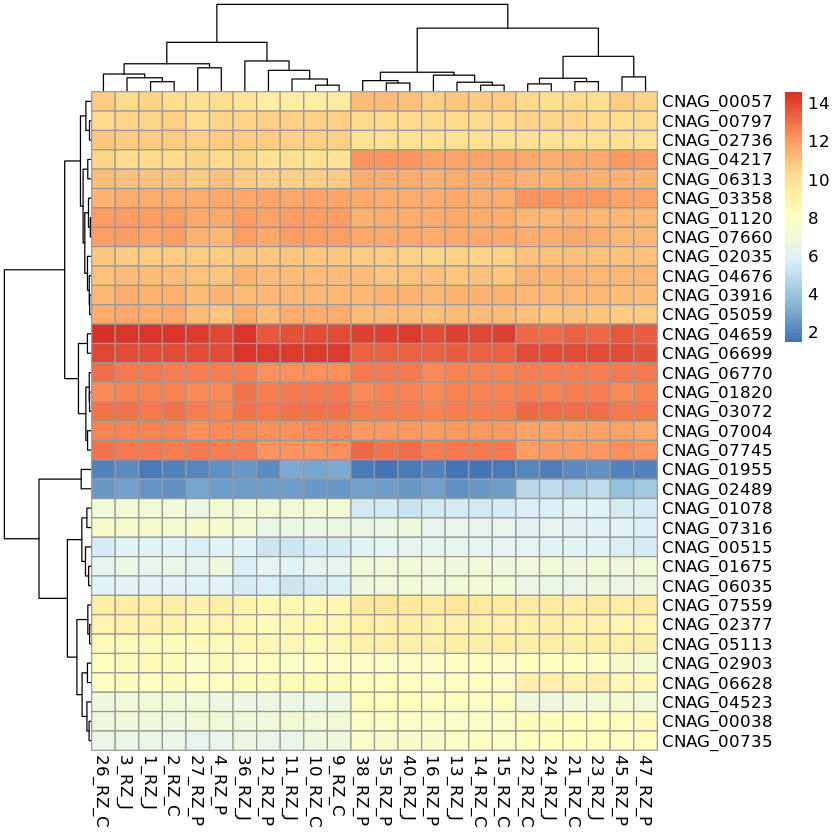

In [54]:
### Heatmap for geneset 1 based on rlog transformed "expressions"
pheatmap(assay(rld)[get_geneset_lst(pathid),])

Of couse, you need to convert the expression of each gene into the same scale to compare them across different samples

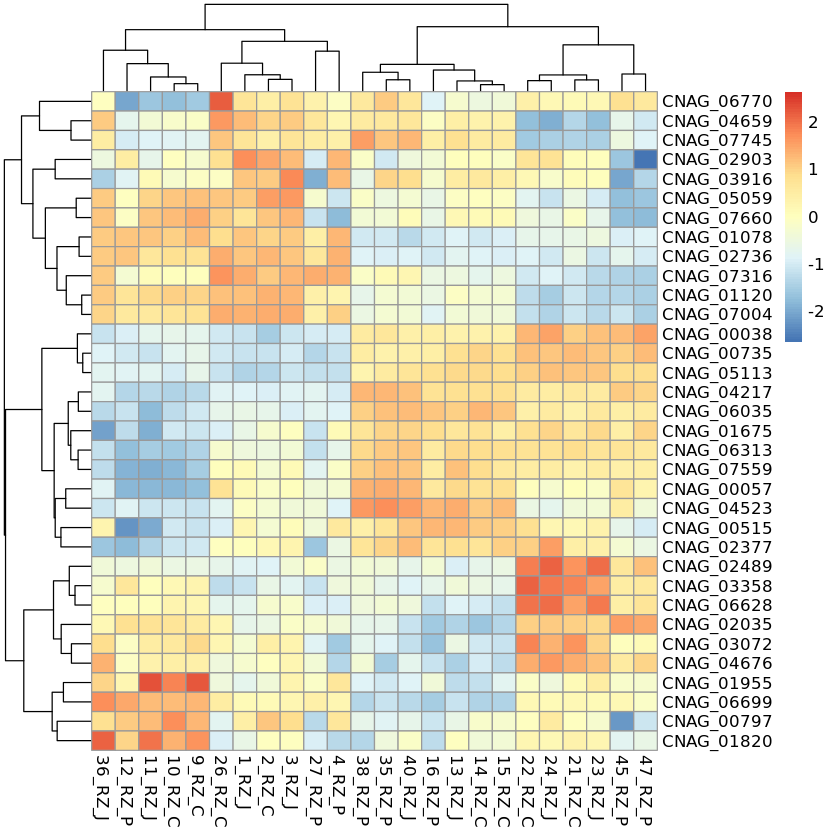

In [25]:
### Be sure to scale across the rows
pheatmap(assay(rld)[get_geneset_lst(pathid),], scale = "row")

The pheatmap function allow you add annotation of samples on the heatmap. It also allow you to control the things (title, legend, dendrogram, etc) you want to show.

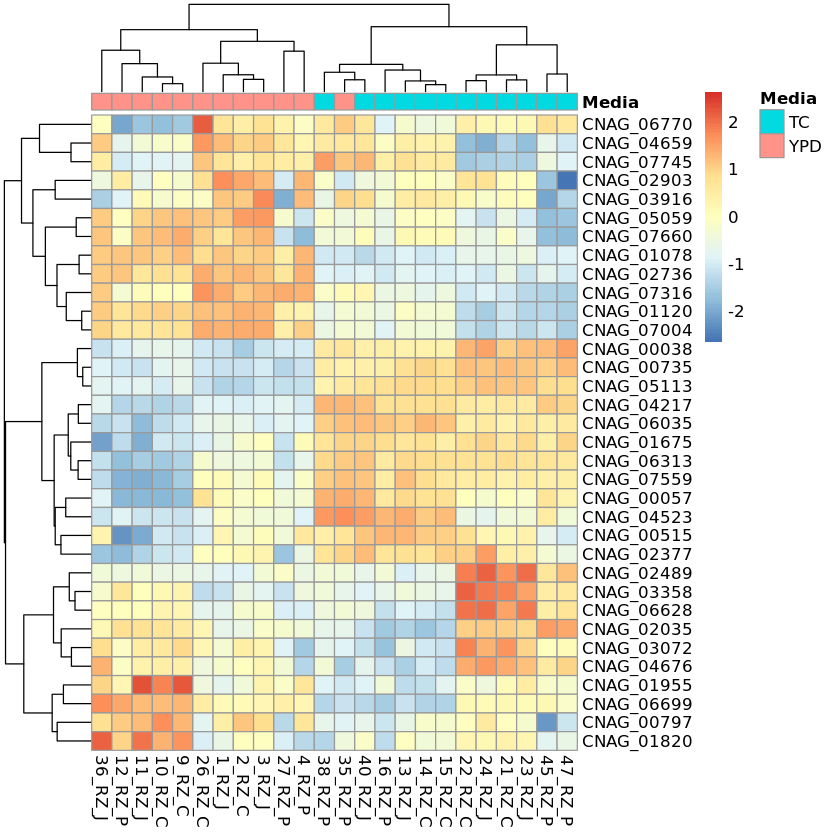

In [55]:
### Annotate heatmap with Media status
annodf <- as.data.frame(colData(rld)[,"Media", drop = FALSE])
pheatmap(assay(rld)[get_geneset_lst(pathid),],
         scale = "row",
         annotation_col = annodf)

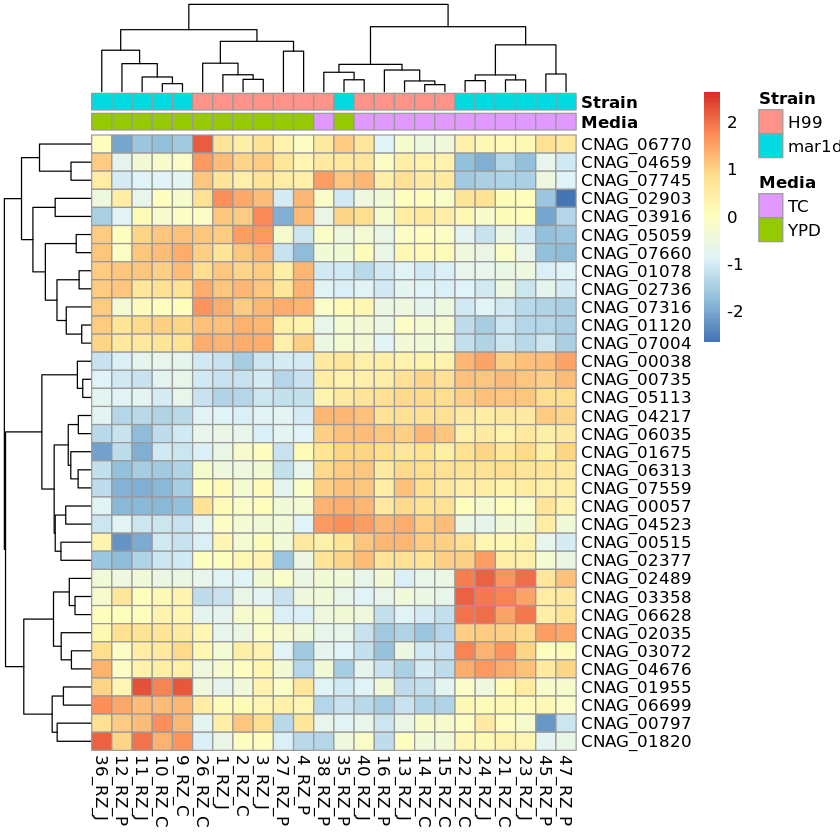

In [56]:
### Annotate heatmap with Media and Strain status
annodf <- as.data.frame(colData(rld)[,c("Media", "Strain"), drop=FALSE])
pheatmap(assay(rld)[get_geneset_lst(pathid),],
         scale = "row",
         annotation_col = annodf)

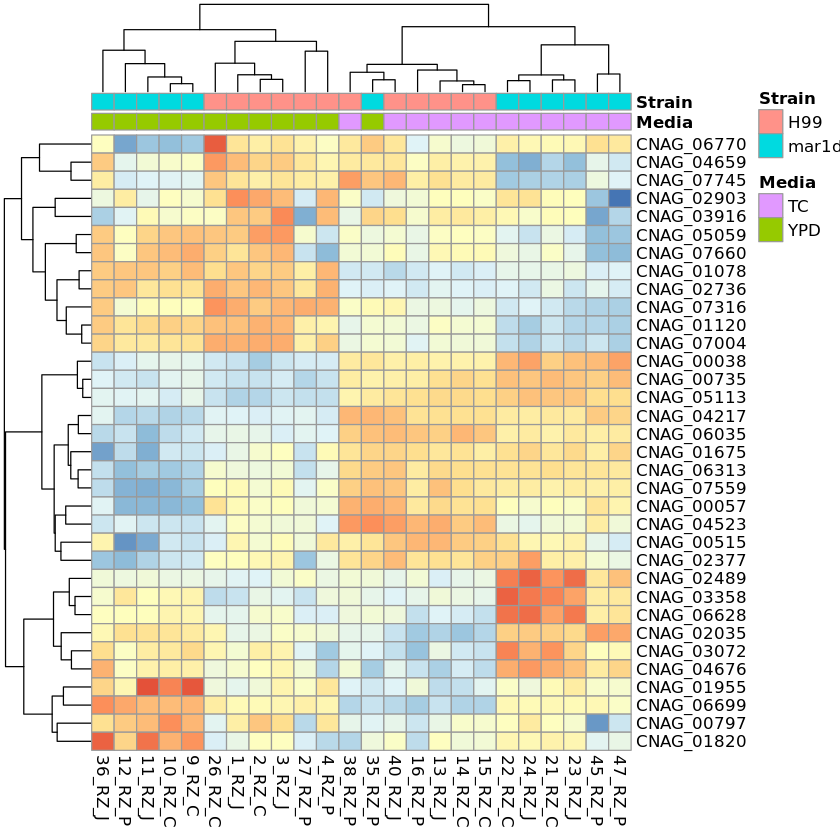

In [57]:
### Add main title and drop legend
annodf <- as.data.frame(colData(rld)[,c("Media", "Strain"), drop=FALSE])
pheatmap(assay(rld)[get_geneset_lst(pathid),],
         scale = "row",
         annotation_col = annodf,
         legend = FALSE)

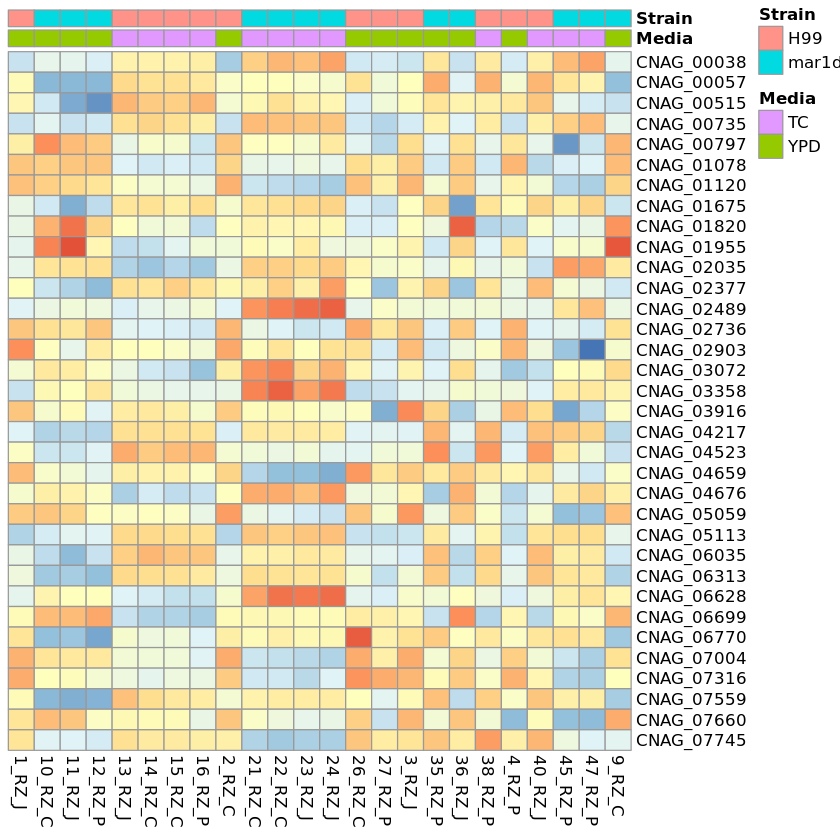

In [58]:
### Add main title, drop legend and disable clustering on columns and rows
annodf <- as.data.frame(colData(rld)[,c("Media", "Strain"), drop=FALSE])
pheatmap(assay(rld)[get_geneset_lst(pathid),],
         scale = "row",
         annotation_col = annodf,
         legend = FALSE,
         cluster_rows = FALSE,
         cluster_cols = FALSE)